In [6]:
import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
#from cftime import datetime 
from datetime import datetime, timedelta
#import datetime as dt
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
from matplotlib.ticker import MaxNLocator
#jet = mcm.get_cmap('jet')
jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')
import netCDF4 as nc
import sys
import os
import psutil
import netCDF4 as nc
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
import time
from time import process_time
from tqdm import tqdm
from dask.distributed import LocalCluster, Client
import dask.array as da
import dask.dataframe as dd
import dask
from dask import delayed
from dask.diagnostics import ProgressBar  # Import the ProgressBar class
import calendar
import glob
%matplotlib inline 
#import line_profiler
#%load_ext line_profiler

/tmp/ipykernel_822641/1870643686.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')


# Mptdens Min & Max Values

In [2]:
fp1 = 'Nc_Files/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-*.nc'
ds = xr.open_mfdataset(fp1)
#ds



timee = ds.variables['time']

lon = ds.variables['lon']
lat = ds.variables['lat']
lev = ds.variables['lev']
dst = ds.transpose("lev", ...)
#geopH = dst.variables['Z3'] / 1000 #m-> km    #(126, 744, 96, 144)        #Mpt = dst.variables['Fep'] 

temp = dst.variables['T']

Fept = dst.variables['Fep']
Mgpt = dst.variables['Mgp']
Napt = dst.variables['Nap']


lev_sl_idx_min = 41      
lev_sl_idx_max = 60 

lev_sl = lev[lev_sl_idx_min:lev_sl_idx_max+1]

tempe = temp[lev_sl_idx_min:lev_sl_idx_max+1,:,:,:]

Fep_t = Fept[lev_sl_idx_min:lev_sl_idx_max+1,:,:,:]
Mgp_t = Mgpt[lev_sl_idx_min:lev_sl_idx_max+1,:,:,:]
Nap_t = Napt[lev_sl_idx_min:lev_sl_idx_max+1,:,:,:]


Feptdens = ( Fep_t * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe)
Mgptdens = ( Mgp_t * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe)
Naptdens = ( Nap_t * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe)
            
Mptdens = Feptdens + (2 * Mgptdens ) + Naptdens    # equivalent to [Fep] * Factor where Factor = (Fep+2Mgp+Nap)/Fep



In [10]:
min_values = np.min(Mptdens, axis=(0, 1, 2, 3))
max_values = np.max(Mptdens, axis=(0, 1, 2, 3))

min_value = np.min(min_values)
print(f'Mptdens min = {min_value.values}')   #Mptdens min = 9.222161535569176e-06

max_value = np.max(max_values)
print(f'Mptdens max = {max_value.values}')  #Mptdens max = 3563445.6983512472


Mptdens min = 9.222161535569176e-06
Mptdens max = 3563445.6983512472


# Histogram

In [7]:
bin_edges = np.logspace(np.log10(5e2), np.log10(5e6), 101)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = np.diff(bin_edges)
num_bins = len(bin_midpoints)

# # Print the results
# print("Bin Edges (Lower and Upper):")
# for i in range(len(bin_edges) - 1):
#     print(f"Bin {i + 1}: [{bin_edges[i]}, {bin_edges[i + 1]}]")

# print("\nBin Midpoints:")
# for i in range(len(bin_midpoints)):
#     print(f"Bin {i + 1} Midpoint: {bin_midpoints[i]}")

# print("\nBin Widths:", bin_widths)
print(f"Number of Bins: {num_bins}")

Number of Bins: 100


In [8]:

seasons = [ 'Dec-Feb']#, 'Mar-May', 'Jun-Aug', 'Sep-Nov' ]

for season in seasons:
    
    testds = xr.open_dataset(f'Nc_Files/SpE_Output/Wuhu_IonTr_run_SpE_Output_{season}.nc')
    SpEsns = testds['SpEsns']   #'lev_sl', 'time', 'lat', 'lon', 'timesl', 'mth'  (20,336,96,144,2,3)
    flattened_SpEsns = SpEsns.values.flatten()

    # Initialize an array to store histogram counts for each bin
    histogram_counts = np.zeros(len(bin_edges) - 1)


    for value in tqdm(flattened_SpEsns):
        if np.isnan(value):
            continue

        # Find the bin index for the value
        bin_index = np.digitize(value, bin_edges, right=True)

        # Increment the corresponding bin in the histogram
        histogram_counts[bin_index - 1] += 1
        
        
    output_nc_file = f'./Nc_Files/e_histogram/{season}_e_histogram_data.nc'
    with nc.Dataset(output_nc_file, 'w') as dataset:
        # Create dimensions
        dataset.createDimension('num_bins', num_bins)
        dataset.createDimension('bin_edges', num_bins+1)

        # Create variables
        bin_edges_var = dataset.createVariable('bin_edges', 'f8', ('bin_edges',))
        bin_midpoints_var = dataset.createVariable('bin_midpoints', 'f8', ('num_bins',))
        bin_widths_var = dataset.createVariable('bin_widths', 'f8', ('num_bins',))
        histogram_counts_var = dataset.createVariable('histogram_counts', 'i4', ('num_bins',))

        # Assign values to variables
        bin_edges_var[:] = bin_edges
        bin_midpoints_var[:] = bin_midpoints
        bin_widths_var[:] = bin_widths
        histogram_counts_var[:] = histogram_counts

    print(f"Histogram data saved to {output_nc_file}")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 557383680/557383680 [09:32<00:00, 973365.36it/s]


Histogram data saved to ./Nc_Files/e_histogram/Dec-Feb_e_histogram_data.nc


In [9]:
season = 'Dec-Feb'
resultds = xr.open_dataset(f'Nc_Files/e_histogram/{season}_e_histogram_data.nc')
histogram_counts = resultds['histogram_counts']

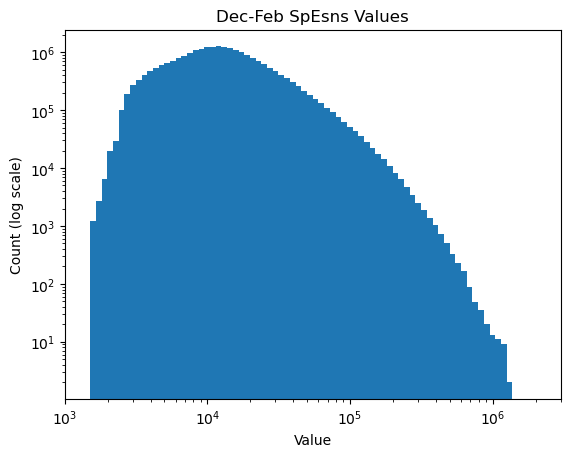

In [10]:


plt.bar(bin_edges[:-1], histogram_counts, width=np.diff(bin_edges), align='edge', log=True)

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Count (log scale)')
plt.title(f'{season} SpEsns Values')
plt.xscale('log')
plt.xlim(1e3,3e6)
# Show the plot
plt.show()

In [11]:
for edge, count in zip(bin_edges[:-1], histogram_counts.values):
    print(f'Bin Edge: {edge:.2e}, Count: {count}')


Bin Edge: 5.00e+02, Count: 0
Bin Edge: 5.48e+02, Count: 0
Bin Edge: 6.01e+02, Count: 0
Bin Edge: 6.59e+02, Count: 0
Bin Edge: 7.23e+02, Count: 0
Bin Edge: 7.92e+02, Count: 0
Bin Edge: 8.69e+02, Count: 0
Bin Edge: 9.53e+02, Count: 0
Bin Edge: 1.04e+03, Count: 0
Bin Edge: 1.15e+03, Count: 0
Bin Edge: 1.26e+03, Count: 0
Bin Edge: 1.38e+03, Count: 0
Bin Edge: 1.51e+03, Count: 1214
Bin Edge: 1.66e+03, Count: 2730
Bin Edge: 1.82e+03, Count: 6415
Bin Edge: 1.99e+03, Count: 19553
Bin Edge: 2.18e+03, Count: 29190
Bin Edge: 2.39e+03, Count: 98517
Bin Edge: 2.62e+03, Count: 190885
Bin Edge: 2.88e+03, Count: 268715
Bin Edge: 3.15e+03, Count: 331750
Bin Edge: 3.46e+03, Count: 401239
Bin Edge: 3.79e+03, Count: 473976
Bin Edge: 4.16e+03, Count: 535991
Bin Edge: 4.56e+03, Count: 598481
Bin Edge: 5.00e+03, Count: 661387
Bin Edge: 5.48e+03, Count: 711274
Bin Edge: 6.01e+03, Count: 778039
Bin Edge: 6.59e+03, Count: 857039
Bin Edge: 7.23e+03, Count: 984365
Bin Edge: 7.92e+03, Count: 1080168
Bin Edge: 8.69

In [ ]:
#Winter

# Bin Edge: 1.26e+03, Count: 0
# Bin Edge: 1.38e+03, Count: 0
# Bin Edge: 1.51e+03, Count: 1214
# Bin Edge: 1.66e+03, Count: 2730
# Bin Edge: 1.82e+03, Count: 6415
# Bin Edge: 1.99e+03, Count: 19553
#.........
# Bin Edge: 1.04e+06, Count: 11
# Bin Edge: 1.15e+06, Count: 9
# Bin Edge: 1.26e+06, Count: 2
# Bin Edge: 1.38e+06, Count: 0
# Bin Edge: 1.51e+06, Count: 0

# Min
critfreq = (8.98 * np.sqrt(1.51e+03*1e6) ) * 1e-6
critfreq #0.34895129172994904

# Max
critfreq = (8.98 * np.sqrt(1.26e+06*1e6) ) * 1e-6
critfreq #10.080024999968998

# At peak

critfreq = (8.98 * np.sqrt(1.15e+04*1e6) ) * 1e-6
critfreq #0.9629977154697721
